# Predict credit card default

#### Goal: Explores the use of logistic regression models to predict credit card default 

In [1]:
%matplotlib inline

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Load data

In [2]:
credit_df = pd.read_excel('default of credit card clients.xls',header=1)
credit_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Get overall default rate
default_pct = (credit_df['default payment next month'].sum()/float(credit_df.shape[0]))*100
print(str(int(default_pct)) +"% of consumers defaulted on the following month's payment")

22% of consumers defaulted on the following month's payment


### Visualize the relationship between some potentially predictative features and the target (default or not)

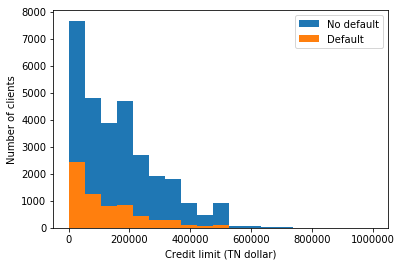

In [4]:
binBoundaries = np.linspace(0,1000000,20)
plt.hist(credit_df['LIMIT_BAL'], bins=binBoundaries);
plt.hist(credit_df.loc[credit_df['default payment next month']==1]['LIMIT_BAL'], bins=binBoundaries);
plt.legend(['No default','Default'])
plt.xlabel('Credit limit (TN dollar)')
plt.ylabel('Number of clients')
plt.show()

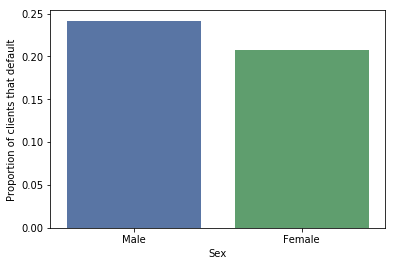

In [5]:
ax = sns.barplot(data=credit_df, x='SEX', y='default payment next month', palette='deep', ci=None)
ax.set_xticklabels(['Male','Female'])
ax.set(xlabel='Sex', ylabel='Proportion of clients that default');

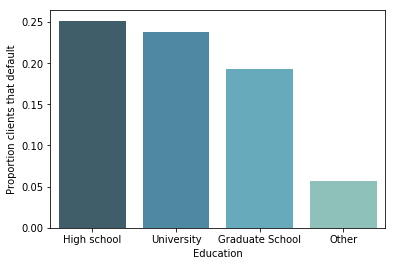

In [6]:
ax = sns.barplot(data=credit_df[(credit_df['EDUCATION']!=0) &
                               (credit_df['EDUCATION']!=5) &
                               (credit_df['EDUCATION']!=6)], x='EDUCATION', y='default payment next month', palette='GnBu_d', ci=None,
                order=[3,2,1,4])
ax.set_xticklabels(['High school','University','Graduate School','Other'])
ax.set(xlabel='Education', ylabel='Proportion clients that default');

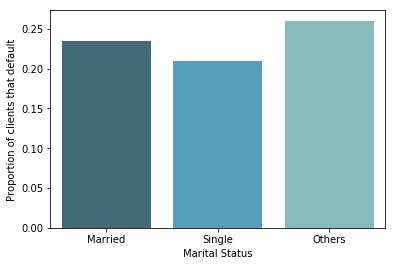

In [7]:
ax = sns.barplot(data=credit_df[credit_df['MARRIAGE']!=0], x='MARRIAGE', y='default payment next month', palette='GnBu_d', ci=None)
ax.set_xticklabels(['Married','Single','Others'])
ax.set(xlabel='Marital Status', ylabel='Proportion of clients that default');

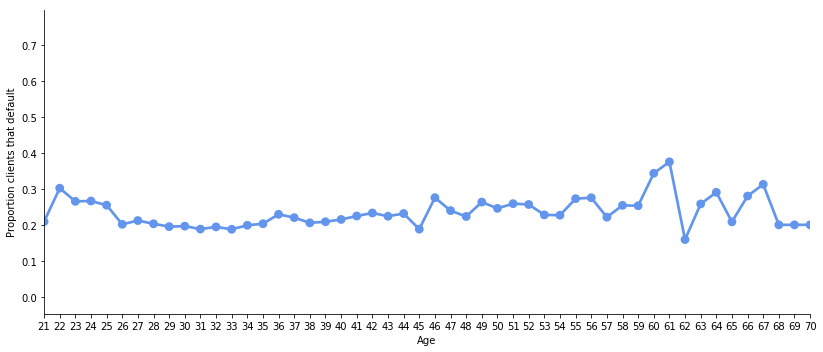

In [8]:
ax = sns.factorplot(data=credit_df, x='AGE', y='default payment next month', ci=None, color='cornflowerblue',size=5,aspect=2.3)
plt.xlim(0, 49)
plt.xlabel('Age')
plt.ylabel('Proportion clients that default');

### Check which predictors are correlated

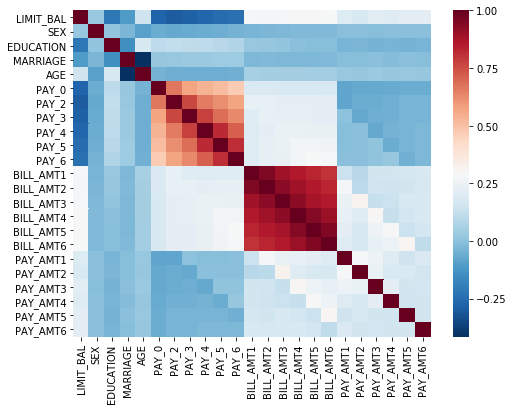

In [9]:
X = credit_df.drop(['ID','default payment next month'], axis=1)
X_corr = X.corr()
Y = credit_df['default payment next month']

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(X_corr,
           xticklabels=X_corr.columns,
           yticklabels=X_corr.columns,
           cmap = 'RdBu_r');

### Predict default using logistic regression models

In [10]:
# Prototype model
credit_model = LogisticRegression()
credit_model.fit(X,Y)
Y_pred = credit_model.predict(X)

print ("The accuracy rate of the model on the entire dataset is " +str(int(accuracy_score(Y, Y_pred)*100)) +"%.")

The accuracy rate of the model on the entire dataset is 77%.


In [11]:
Y_pred.sum()

2

But the model is blindly always predicting "No default".

In [12]:
print(classification_report(Y,Y_pred))

             precision    recall  f1-score   support

          0       0.78      1.00      0.88     23364
          1       0.00      0.00      0.00      6636

avg / total       0.61      0.78      0.68     30000



Potentially due to class imbalance in the data set; there are more "no defaults" than "defaults".

### Alternate approach #1: Balance the original dataset with equal number of samples for default vs. non-default

In [13]:
n_default = credit_df['default payment next month'].sum()
n_rows = credit_df.shape[0]
rebal_frac = n_default/float((n_rows - n_default)) # Fraction of non-default samples to keep to balance
credit_df_bal = pd.concat([credit_df[credit_df['default payment next month']==0].sample(frac=rebal_frac),
                                   credit_df[credit_df['default payment next month']==1]]);
print(credit_df_bal['default payment next month'].value_counts());
credit_df_bal.head();

1    6636
0    6636
Name: default payment next month, dtype: int64


In [14]:
# Model using balanced dataset
X_bal = credit_df_bal.drop(['ID','default payment next month'], axis=1)
Y_bal = credit_df_bal['default payment next month']
credit_model_bal = LogisticRegression()
credit_model_bal.fit(X_bal,Y_bal)
Y_bal_pred = credit_model.predict(X_bal)
print("The accuracy rate of the model on the entire dataset is " +str(int(accuracy_score(Y_bal, Y_bal_pred)*100)) +"%.")

The accuracy rate of the model on the entire dataset is 49%.


In [15]:
Y_bal_pred.sum()

2

Balancing classes did not solve the problem of always predicting no-default.

In [16]:
print(classification_report(Y_bal,Y_bal_pred))

             precision    recall  f1-score   support

          0       0.50      1.00      0.67      6636
          1       0.00      0.00      0.00      6636

avg / total       0.25      0.50      0.33     13272



### Alternate approach #2: More heavily penalize misclassifying the smaller class

In [17]:
credit_model = LogisticRegression(class_weight='balanced')
credit_model.fit(X,Y)
Y_pred = credit_model.predict(X)

print ("The accuracy rate of the model on the entire dataset is " +str(int(credit_model.score(X,Y)*100)) +"%.")

The accuracy rate of the model on the entire dataset is 66%.


In [18]:
Y_pred.sum()

11813

The model is no longer predicting all cases to be one class

In [19]:
print(classification_report(Y,Y_pred))

             precision    recall  f1-score   support

          0       0.87      0.67      0.76     23364
          1       0.36      0.63      0.46      6636

avg / total       0.75      0.66      0.69     30000



In [20]:
# Grid Search to optimize parameters
'''
parameter_grid = {'solver' : ['newton-cg', 'lbfgs','liblinear'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(credit_model, param_grid=parameter_grid)
grid_search.fit(X, Y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
'''

"\nparameter_grid = {'solver' : ['newton-cg', 'lbfgs','liblinear'],\n                  'C' : [0.005, 0.01, 1, 10, 100, 1000, 10000]}\n\ngrid_search = GridSearchCV(credit_model, param_grid=parameter_grid)\ngrid_search.fit(X, Y)\nprint('Best score: {}'.format(grid_search.best_score_))\nprint('Best parameters: {}'.format(grid_search.best_params_))\n"

In [21]:
# Update model with optimized parameters
credit_model = LogisticRegression(class_weight='balanced', C = 1, solver='newton-cg')

### Refit and re-evaluate model using training and validation sets

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state = 42)
credit_model.fit(X_train,Y_train)
Y_test_pred = credit_model.predict(X_test)

print("The accuracy rate of the model on the test dataset is " +str(int(accuracy_score(Y_test, Y_test_pred)*100)) +"%.")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:461: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


The accuracy rate of the model on the test dataset is 69%.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [23]:
print(classification_report(Y_test,Y_test_pred))

             precision    recall  f1-score   support

          0       0.87      0.71      0.78      5873
          1       0.38      0.63      0.47      1627

avg / total       0.77      0.69      0.72      7500



### Performance of base model for comparison

In [24]:
# Base model of always predicting "No default"
Y_test_base_pred = np.zeros(Y_test.shape[0])
print("The accuracy rate of a simple base model is " +str(int(accuracy_score(Y_test, Y_test_base_pred)*100)) +"%.")

The accuracy rate of a simple base model is 78%.


In [25]:
print(classification_report(Y_test,Y_test_base_pred))

             precision    recall  f1-score   support

          0       0.78      1.00      0.88      5873
          1       0.00      0.00      0.00      1627

avg / total       0.61      0.78      0.69      7500



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In terms of accuracy, this logistic regression model scores lower compared to a simple base model that only predicted "No-default", due to imbalanced classes. However, the regression model has much better precision on predicting cases of default, which is more useful than the base model for decision making.